In [1]:
#Imports
from marketsai.economies.capital_mkts.capital_market import CapitalMarket
import scipy.io as sio
from scipy.interpolate import RegularGridInterpolator
from marketsai.utils import encode
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import csv
import json
from ray.rllib.agents.ppo import PPOTrainer
from ray.tune.registry import register_env
from ray import shutdown, init


/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
""" GLOBAL CONFIGS """
# Script Options
FOR_PUBLIC = True  # for publication
SAVE_CSV = False  # save learning CSV
PLOT_PROGRESS = True  # create plot with progress
SIMUL_PERIODS = 10000
# Input Directories
# Rl experiment
INPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/expINFO_native_multi_hh_cap_market_run_Aug28_PPO.json"
# GDSGE policy
dir_policy_folder = (
    "/Users/matiascovarrubias/Dropbox/RL_macro/Econ_algos/capital_market/Results/"
)

# Output Directories
if FOR_PUBLIC:
    OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/"
    OUTPUT_PATH_FIGURES = "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/"
    OUTPUT_PATH_TABLES = "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Tables/"
else:
    OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/ALL/"
    OUTPUT_PATH_FIGURES = (
        "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/ALL/"
    )
    OUTPUT_PATH_TABLES = "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Tables/"
    

# Plot options
sn.color_palette("Set2")
sn.set_style("ticks")  # grid styling, "dark"
# plt.figure(figure=(8, 4))
# choose between "paper", "talk" or "poster"
sn.set_context(
    "paper",
    font_scale=1.4,
)


In [3]:
""" Step 0: import experiment data and create output data """
with open(INPUT_PATH_EXPERS) as f:
    exp_data_dict = json.load(f)

# UNPACK USEFUL DATA
n_agents_list = exp_data_dict["n_agents"]
exp_names = exp_data_dict["exp_names"]
checkpoints_dirs = exp_data_dict["checkpoints"]
progress_csv_dirs = exp_data_dict["progress_csv_dirs"]
best_rewards = exp_data_dict["best_rewards"]

#Create output directory
exp_data_analysis_dict =  {"n_hh": [], "max rewards": [] , "time to peak": [], "Mean Agg. K": [], "S.D. Agg. K": [], "Max K":[], "Min K": [], "Mean Agg. s": [], "S.D. Agg. s": [], "Max s":[], "Min s":[],  "Mean Price": [], "S.D. Price": []}
exp_data_analysis_econ_dict =  {"n_hh": [] , "time to peak": [], "Mean Agg. K": [], "S.D. Agg. K": [], "Max K":[], "Min K": [], "Mean Agg. s": [], "S.D. Agg. s": [], "Max s":[], "Min s":[],  "Mean Price": [], "S.D. Price": []}
exp_data_simul_dict = {"n_hh": [], "max rewards": [] , "time to peak": [], "Mean Agg. K": [], "S.D. Agg. K": [], "Max K":[], "Min K": [], "Mean Agg. s": [], "S.D. Agg. s": [], "Max s":[], "Min s":[],  "Mean Price": [], "S.D. Price": []}
exp_data_simul_econ_dict = {"n_hh": [] , "time to peak": [], "Mean Agg. K": [], "S.D. Agg. K": [], "Max K":[], "Min K": [], "Mean Agg. s": [], "S.D. Agg. s": [], "Max s":[], "Min s":[],  "Mean Price": [], "S.D. Price": []}
# init ray
shutdown()
init()

2021-08-30 09:28:34,450	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '10.17.83.159',
 'raylet_ip_address': '10.17.83.159',
 'redis_address': '10.17.83.159:60791',
 'object_store_address': '/tmp/ray/session_2021-08-30_09-28-32_954282_34348/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-08-30_09-28-32_954282_34348/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-08-30_09-28-32_954282_34348',
 'metrics_export_port': 62903,
 'node_id': '3adff579d87eaf49d9e21dd3a6a9e4f5fd28a6492c02d88c437c1459'}

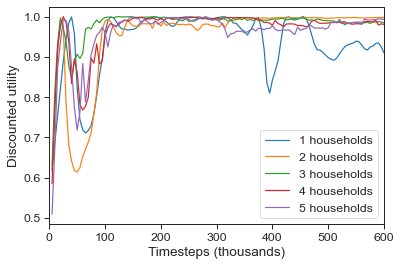

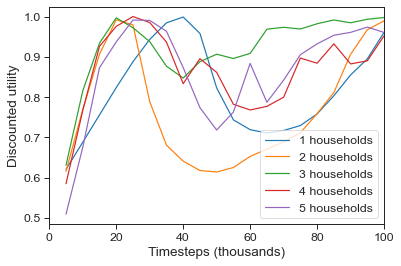

In [4]:

""" Step 1: Plot progress """

if PLOT_PROGRESS == True:
    #Big plot
    for i in range(len(exp_names)):
        data_progress_df = pd.read_csv(progress_csv_dirs[i])
        max_rewards = data_progress_df[
            "evaluation/custom_metrics/discounted_rewards_mean"
        ].max()
        exp_data_simul_dict["max rewards"].append(max_rewards)
        exp_data_simul_dict["time to peak"].append(0)
        exp_data_analysis_dict["max rewards"].append(max_rewards)
        exp_data_analysis_dict["time to peak"].append(0)
        data_progress_df["evaluation/custom_metrics/discounted_rewards_mean"] = (
            data_progress_df["evaluation/custom_metrics/discounted_rewards_mean"]
            / max_rewards
        )
        learning_plot_big = sn.lineplot(
            data=data_progress_df,
            y="evaluation/custom_metrics/discounted_rewards_mean",
            x="episodes_total",
        )


    learning_plot_big = learning_plot_big.get_figure()
    plt.ylabel("Discounted utility")
    plt.xlabel("Timesteps (thousands)")
    plt.xlim([0, 600])
    plt.legend(labels=[f"{i+1} households" for i in range(len(n_agents_list))])
    learning_plot_big.savefig(OUTPUT_PATH_FIGURES + "progress_BIG_" + exp_names[-1] + ".png")
    plt.show()
    plt.close()

    # small plot
    for i in range(len(exp_names)):
        data_progress_df = pd.read_csv(progress_csv_dirs[i])
        max_rewards = data_progress_df[
            "evaluation/custom_metrics/discounted_rewards_mean"
        ].max()
        data_progress_df["evaluation/custom_metrics/discounted_rewards_mean"] = (
            data_progress_df["evaluation/custom_metrics/discounted_rewards_mean"]
            / max_rewards
        )
        learning_plot_small = sn.lineplot(
            data=data_progress_df,
            y="evaluation/custom_metrics/discounted_rewards_mean",
            x="episodes_total",
        )


    learning_plot_small = learning_plot_small.get_figure()
    plt.ylabel("Discounted utility")
    plt.xlabel("Timesteps (thousands)")
    plt.xlim([0, 100])
    plt.legend(labels=[f"{i+1} households" for i in range(len(n_agents_list))])
    learning_plot_small.savefig(OUTPUT_PATH_FIGURES + "progress_SMALL_" + exp_names[-1] + ".png")
    plt.show()
    plt.close()


2021-08-30 09:28:37,532	INFO trainer.py:694 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=34375) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=34375) Instructions for updating:
(pid=34375) non-resource variables are not supported in the long term
(pid=34376) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=34376) Instructions for updating:
(pid=34376) non-resource variables are not supported in t

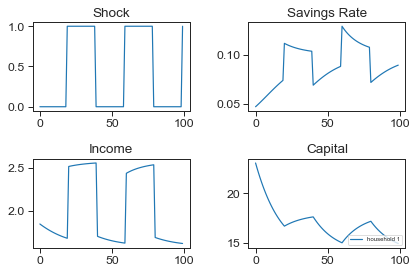

(pid=34380) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=34380) Instructions for updating:
(pid=34380) non-resource variables are not supported in the long term
(pid=34371) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=34371) Instructions for updating:
(pid=34371) non-resource variables are not supported in the long term
2021-08-30 09:28:44,084	INFO trainable.py:377 -- Restored on 10.17.83.159 from checkpoint: /Users/matiascovarrubias/ray_results/native_2hh_cap_mar

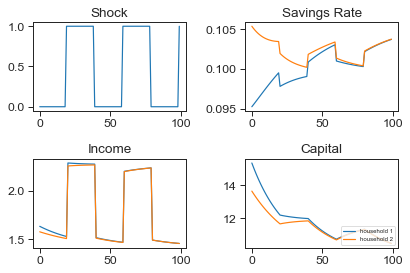

(pid=34379) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=34379) Instructions for updating:
(pid=34379) non-resource variables are not supported in the long term
(pid=34377) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=34377) Instructions for updating:
(pid=34377) non-resource variables are not supported in the long term
2021-08-30 09:28:49,121	INFO trainable.py:377 -- Restored on 10.17.83.159 from checkpoint: /Users/matiascovarrubias/ray_results/native_3hh_cap_mar

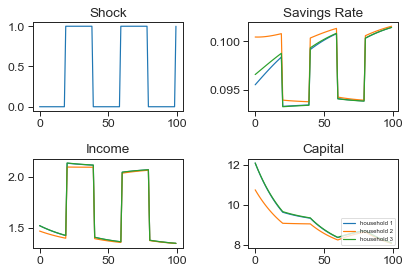

(pid=34367) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=34367) Instructions for updating:
(pid=34367) non-resource variables are not supported in the long term
(pid=34378) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=34378) Instructions for updating:
(pid=34378) non-resource variables are not supported in the long term
2021-08-30 09:28:55,309	INFO trainable.py:377 -- Restored on 10.17.83.159 from checkpoint: /Users/matiascovarrubias/ray_results/native_4hh_cap_mar

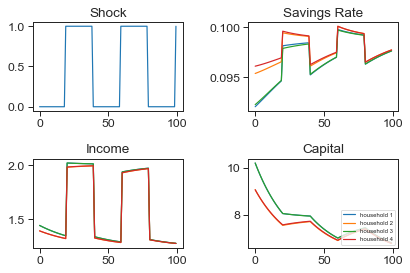

(pid=34373) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=34373) Instructions for updating:
(pid=34373) non-resource variables are not supported in the long term
(pid=34372) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=34372) Instructions for updating:
(pid=34372) non-resource variables are not supported in the long term
2021-08-30 09:29:02,328	INFO trainable.py:377 -- Restored on 10.17.83.159 from checkpoint: /Users/matiascovarrubias/ray_results/native_5hh_cap_mar

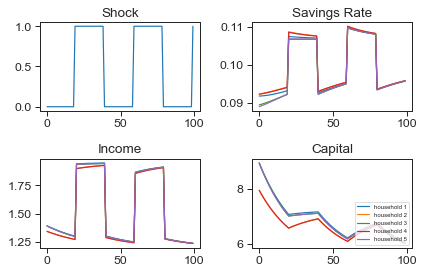

{'n_hh': [1, 2, 3, 4, 5], 'max rewards': [36.16338369777727, 29.989998349633854, 26.42239586655694, 23.958705000229447, 22.067549325604165], 'time to peak': [0, 0, 0, 0, 0], 'Mean Agg. K': [16.112450683200613, 21.712127499312558, 25.000152599896833, 28.340015121909808, 31.783723858202993], 'S.D. Agg. K': [0.8914148211789674, 0.8978493888020647, 1.177856678404343, 1.273637070708092, 1.4690067467023673], 'Max K': [23.070843176993726, 15.345710435576311, 12.089376568377975, 10.207291817031962, 8.951681899534016], 'Min K': [14.863345121034602, 10.365420354427798, 7.980902757285033, 6.72794580226963, 5.972691017318089], 'Mean Agg. s': [0.09858535427749154, 0.10205301792089276, 0.09759488794107443, 0.09846705038585868, 0.10202575168389458], 'S.D. Agg. s': [0.01894806100270549, 0.0011998675449531942, 0.0035007784460228167, 0.0014261758449840203, 0.007331837407966615], 'Max s': [0.1306907683610916, 0.10538664758205413, 0.10165341496467589, 0.1003722846508026, 0.1106856733560562], 'Min s': [0.0

In [5]:

""" Step 2: Congif, Restore RL policy and then simualte analysis trajectory """
y_agg_list = [[] for i in n_agents_list]
s_agg_list = [[] for i in n_agents_list]
c_agg_list = [[] for i in n_agents_list]
k_agg_list = [[] for i in n_agents_list]
k_max_list = [[] for i in n_agents_list]
k_min_list = [[] for i in n_agents_list]
s_max_list = [[] for i in n_agents_list]
s_min_list = [[] for i in n_agents_list]
shock_agg_list = [[] for i in n_agents_list]
p_list = [[] for i in n_agents_list]

for ind, n_hh in enumerate(n_agents_list):
    """ Step 2.0: replicate original environemnt and config """
    env_label = "capital_market"
    register_env(env_label, CapitalMarket)
    env_horizon = 1000
    n_hh = n_hh
    n_capital = 1
    beta = 0.98
    env_config_analysis = {
        "horizon": 1000,
        "n_hh": n_hh,
        "n_capital": n_capital,
        "eval_mode": False,
        "simul_mode": False,
        "analysis_mode": True,
        "max_savings": 0.6,
        "bgt_penalty": 1,
        "shock_idtc_values": [0.9, 1.1],
        "shock_idtc_transition": [[0.9, 0.1], [0.1, 0.9]],
        "shock_agg_values": [0.8, 1.2],
        "shock_agg_transition": [[0.95, 0.05], [0.05, 0.95]],
        "parameters": {"delta": 0.04, "alpha": 0.3, "phi": 0.5, "beta": beta},
    }

    # We instantiate the environment to extract information.
    env = CapitalMarket(env_config_analysis)
    config_analysis = {
        "gamma": beta,
        "env": env_label,
        "env_config": env_config_analysis,
        "horizon": env_horizon,
        "explore": False,
        "framework": "torch",
        "multiagent": {
            "policies": {
                "hh": (
                    None,
                    env.observation_space["hh_0"],
                    env.action_space["hh_0"],
                    {},
                ),
            },
            "policy_mapping_fn": (lambda agent_id: agent_id.split("_")[0]),
            "replay_mode": "independent",
        },
    }
    """ Step 2.1: restore trainer """

    # restore the trainer
    trained_trainer = PPOTrainer(env=env_label, config=config_analysis)
    trained_trainer.restore(checkpoints_dirs[ind])

    """ Step 2: Simulate an episode (MAX_steps timesteps) """
    shock_idtc_list = [[] for i in range(env.n_hh)]
    y_list = [[] for i in range(env.n_hh)]
    s_list = [[] for i in range(env.n_hh)]
    c_list = [[] for i in range(env.n_hh)]
    k_list = [[] for i in range(env.n_hh)]

    # loop
    obs = env.reset()
    for t in range(env_horizon):
        action = {}
        for i in range(env.n_hh):
            action[f"hh_{i}"] = trained_trainer.compute_action(
                obs[f"hh_{i}"], policy_id="hh"
            )

        obs, rew, done, info = env.step(action)
        for i in range(env.n_hh):
            shock_idtc_list[i].append(obs["hh_0"][1][i])
            y_list[i].append(info["hh_0"]["income"][i])
            s_list[i].append(info["hh_0"]["savings"][i][0])
            c_list[i].append(info["hh_0"]["consumption"][i])
            k_list[i].append(info["hh_0"]["capital"][i][0])

        # k_agg_list.append(np.sum([k_list[[j][t-1] for j in range(env_loop.n_hh)]))
        shock_agg_list[ind].append(obs["hh_0"][2])
        y_agg_list[ind].append(np.sum([y_list[i][t] for i in range(env.n_hh)]))
        s_agg_list[ind].append(
            np.sum([s_list[i][t] * y_list[i][t] for i in range(env.n_hh)])
            / y_agg_list[ind][t]
        )
        c_agg_list[ind].append(np.sum([y_list[i][t] for i in range(env.n_hh)]))
        k_agg_list[ind].append(np.sum([k_list[i][t] for i in range(env.n_hh)]))
        k_max_list[ind].append(np.max([k_list[i][t] for i in range(env.n_hh)]))
        k_min_list[ind].append(np.min([k_list[i][t] for i in range(env.n_hh)]))
        s_max_list[ind].append(np.max([s_list[i][t] for i in range(env.n_hh)]))
        s_min_list[ind].append(np.min([s_list[i][t] for i in range(env.n_hh)]))
        p_list[ind].append(info["hh_0"]["price"][0])

    """ Step 2.2: Calculate Statistics and save in table """


    exp_data_analysis_dict["n_hh"].append(n_hh)
    exp_data_analysis_dict["Mean Agg. K"].append(np.mean(k_agg_list[ind]))
    exp_data_analysis_dict["S.D. Agg. K"].append(np.std(k_agg_list[ind]))
    exp_data_analysis_dict["Max K"].append(np.max(k_max_list[ind]))
    exp_data_analysis_dict["Min K"].append(np.min(k_min_list[ind]))
    exp_data_analysis_dict["Mean Agg. s"].append(np.mean(s_agg_list[ind]))
    exp_data_analysis_dict["S.D. Agg. s"].append(np.std(s_agg_list[ind]))
    exp_data_analysis_dict["Max s"].append(np.max(s_max_list[ind]))
    exp_data_analysis_dict["Min s"].append(np.min(s_min_list[ind]))
    exp_data_analysis_dict["Mean Price"].append(np.mean(p_list[ind]))
    #exp_data_analysis_dict["S.D. Price"].append(np.std(p_list[ind]))


    """ Step 2.3: Plot trajectories """

    # Idiosyncratic trajectories
    x = [i for i in range(100)]
    plt.subplot(2, 2, 1)
    sn.lineplot(x,shock_agg_list[ind][:100], label = f"household {i+1}", legend=0)
    plt.title("Shock")

    plt.subplot(2, 2, 2)
    for i in range(env.n_hh):
        sn.lineplot(x,s_list[i][:100], label = f"household {i+1}", legend=0)
    plt.title("Savings Rate")

    plt.subplot(2, 2, 3)
    for i in range(env.n_hh):
        sn.lineplot(x,y_list[i][:100], label = f"household {i+1}", legend=0)
    plt.title("Income")

    plt.subplot(2, 2, 4)
    # plt.plot(k_agg_list[:100])
    for i in range(env.n_hh):
        sn.lineplot(x,k_list[i][:100], label = f"household {i+1}", legend=0)
    plt.title("Capital")
    
    plt.tight_layout()
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower right', prop={'size': 6})
    #plt.legend(labels=[f"{i+1} households" for i in range(env.n_hh)], loc='upper center', bbox_to_anchor=(0.5, 1.05))
    plt.savefig(OUTPUT_PATH_FIGURES + "SimInd_" + exp_names[ind] + ".png")
    plt.show()
    plt.close()
 
print(exp_data_analysis_dict)

/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y

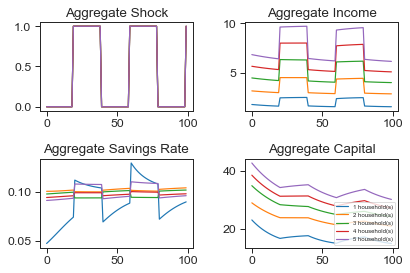

In [6]:
""" Step 3: Create aggregate plots for """

x = [i for i in range(100)]
plt.subplot(2, 2, 1)
for i in range(len(n_agents_list)):
    sn.lineplot(x,shock_agg_list[i][:100], label = f"{i+1} household(s)", legend=0)
plt.title("Aggregate Shock")

plt.subplot(2, 2, 2)
for i in range(len(n_agents_list)):
    sn.lineplot(x,y_agg_list[i][:100], label = f"{i+1} household(s)", legend=0)
plt.title("Aggregate Income")

plt.subplot(2, 2, 3)
for i in range(len(n_agents_list)):
    sn.lineplot(x,s_agg_list[i][:100], label = f"{i+1} household(s)", legend=0)
plt.title("Aggregate Savings Rate")

plt.subplot(2, 2, 4)
for i in range(len(n_agents_list)):
    sn.lineplot(x,k_agg_list[i][:100], label = f"{i+1} household(s)", legend=0)
plt.title("Aggregate Capital")

plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='lower right', prop={'size': 6})
plt.savefig(OUTPUT_PATH_FIGURES + "SimAgg_" + exp_names[-1] + ".png")
plt.clf
plt.show()

/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y

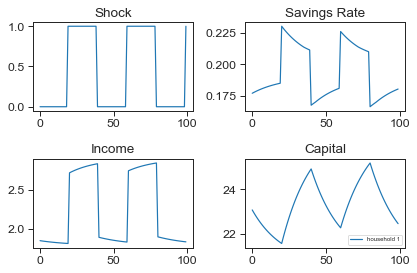

/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y

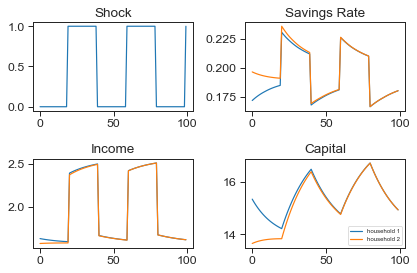

/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y

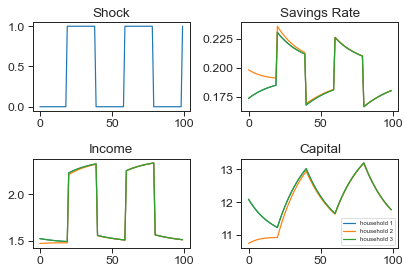

{'n_hh': [1, 2, 3], 'time to peak': [0.360690624, 3.464162213, 466.739593142], 'Mean Agg. K': [23.758805394499493, 31.58146500656931, 37.34464469393524], 'S.D. Agg. K': [0.8702794445494026, 1.2143997496848833, 1.41097594636211], 'Max K': [25.219678884157215, 16.782128478769312, 13.224581728146067], 'Min K': [21.566544627005978, 13.640631498290055, 10.746112505224868], 'Mean Agg. s': [0.195306553107028, 0.19557749838732588, 0.1956220663192174], 'S.D. Agg. s': [0.021430369531096855, 0.021448608648555925, 0.02144995286554222], 'Max s': [0.23008877550427934, 0.23585906301914647, 0.23582304789712347], 'Min s': [0.16624328335569735, 0.16630418439734843, 0.16639700238808358], 'Mean Price': [0.47625052574357196, 0.6339182576432228, 0.7492673336499343], 'S.D. Price': [0.07387301859465722, 0.0983244003917377, 0.11621825956248936]}


In [7]:
""" Step 4: Restore GDSGE policy """
y_agg_list = [[] for i in n_agents_list]
s_agg_list = [[] for i in n_agents_list]
c_agg_list = [[] for i in n_agents_list]
k_agg_list = [[] for i in n_agents_list]
k_max_list = [[] for i in n_agents_list]
k_min_list = [[] for i in n_agents_list]
s_max_list = [[] for i in n_agents_list]
s_min_list = [[] for i in n_agents_list]
shock_agg_list = [[] for i in n_agents_list]
p_list = [[] for i in n_agents_list]

for ind, n_hh in enumerate([1, 2, 3]):
    # replicate environment
    env_label = "capital_market"
    register_env(env_label, CapitalMarket)
    env_horizon = 1000
    n_hh = n_hh
    n_capital = 1
    beta = 0.98
    env_config_analysis = {
        "horizon": 1000,
        "n_hh": n_hh,
        "n_capital": n_capital,
        "eval_mode": False,
        "simul_mode": False,
        "analysis_mode": True,
        "max_savings": 0.6,
        "bgt_penalty": 1,
        "shock_idtc_values": [0.9, 1.1],
        "shock_idtc_transition": [[0.9, 0.1], [0.1, 0.9]],
        "shock_agg_values": [0.8, 1.2],
        "shock_agg_transition": [[0.95, 0.05], [0.05, 0.95]],
        "parameters": {"delta": 0.04, "alpha": 0.3, "phi": 0.5, "beta": beta},
    }

    # We instantiate the environment to extract information.
    env = CapitalMarket(env_config_analysis)
    config_analysis = {
        "gamma": beta,
        "env": env_label,
        "env_config": env_config_analysis,
        "horizon": env_horizon,
        "explore": False,
        "framework": "torch",
        "multiagent": {
            "policies": {
                "hh": (
                    None,
                    env.observation_space["hh_0"],
                    env.action_space["hh_0"],
                    {},
                ),
            },
            "policy_mapping_fn": (lambda agent_id: agent_id.split("_")[0]),
            "replay_mode": "independent",
        },
    }
    """ Step 4.1: import matlab struct """

    dir_model = f"cap_market_{n_hh}hh_11pts"
    matlab_struct = sio.loadmat(dir_policy_folder + dir_model, simplify_cells=True)
    exp_data_analysis_econ_dict["time to peak"].append(
        matlab_struct["IterRslt"]["timeElapsed"]
    )
    exp_data_simul_econ_dict["time to peak"].append(
        matlab_struct["IterRslt"]["timeElapsed"]
    )
    if n_hh == 1:
        K_grid = [
            np.array(matlab_struct["IterRslt"]["var_state"][f"K"]) for i in range(n_hh)
        ]
    else:
        K_grid = [
            np.array(matlab_struct["IterRslt"]["var_state"][f"K_{i+1}"])
            for i in range(n_hh)
        ]
    shock_grid = np.array([i for i in range(matlab_struct["IterRslt"]["shock_num"])])
    if n_hh == 1:
        s_on_grid = [matlab_struct["IterRslt"]["var_policy"]["s"] for i in range(n_hh)]
    else:
        s_on_grid = [
            matlab_struct["IterRslt"]["var_policy"][f"s_{i+1}"] for i in range(n_hh)
        ]

    s_interp = [
        RegularGridInterpolator((shock_grid,) + tuple(K_grid), s_on_grid[i])
        for i in range(n_hh)
    ]

    def compute_action(obs, policy_list: list, max_action: float):
        K = obs[0]
        shock_raw = [obs[2]] + list(obs[1])
        shock_id = encode(shock_raw, dims=[2 for i in range(env.n_hh + 1)])
        s = [policy_list[i](np.array([shock_id] + K)) for i in range(env.n_hh)]
        action = np.array([2 * s[i] / max_action - 1 for i in range(env.n_hh)])
        return action

    """ Step 4.2: Simulate an episode (MAX_steps timesteps) """
    shock_idtc_list = [[] for i in range(env.n_hh)]
    y_list = [[] for i in range(env.n_hh)]
    s_list = [[] for i in range(env.n_hh)]
    c_list = [[] for i in range(env.n_hh)]
    k_list = [[] for i in range(env.n_hh)]

    # loop
    obs = env.reset()
    for t in range(env_horizon):
        action = {}
        for i in range(env.n_hh):
            action[f"hh_{i}"] = compute_action(obs["hh_0"], s_interp, env.max_s_ij)[i]

        obs, rew, done, info = env.step(action)
        for i in range(env.n_hh):
            shock_idtc_list[i].append(obs["hh_0"][1][i])
            y_list[i].append(info["hh_0"]["income"][i])
            s_list[i].append(info["hh_0"]["savings"][i][0])
            c_list[i].append(info["hh_0"]["consumption"][i])
            k_list[i].append(info["hh_0"]["capital"][i][0])

        # k_agg_list.append(np.sum([k_list[[j][t-1] for j in range(env_loop.n_hh)]))
        shock_agg_list[ind].append(obs["hh_0"][2])
        y_agg_list[ind].append(np.sum([y_list[i][t] for i in range(env.n_hh)]))
        s_agg_list[ind].append(
            np.sum([s_list[i][t] * y_list[i][t] for i in range(env.n_hh)])
            / y_agg_list[ind][t]
        )
        c_agg_list[ind].append(np.sum([y_list[i][t] for i in range(env.n_hh)]))
        k_agg_list[ind].append(np.sum([k_list[i][t] for i in range(env.n_hh)]))
        k_max_list[ind].append(np.max([k_list[i][t] for i in range(env.n_hh)]))
        k_min_list[ind].append(np.min([k_list[i][t] for i in range(env.n_hh)]))
        s_max_list[ind].append(np.max([s_list[i][t] for i in range(env.n_hh)]))
        s_min_list[ind].append(np.min([s_list[i][t] for i in range(env.n_hh)]))
        p_list[ind].append(info["hh_0"]["price"][0])

    """ Step 4.3: Calculate Statistics and save in table """

    exp_data_analysis_econ_dict["n_hh"].append(n_hh)
    exp_data_analysis_econ_dict["Mean Agg. K"].append(np.mean(k_agg_list[ind]))
    exp_data_analysis_econ_dict["S.D. Agg. K"].append(np.std(k_agg_list[ind]))
    exp_data_analysis_econ_dict["Max K"].append(np.max(k_max_list[ind]))
    exp_data_analysis_econ_dict["Min K"].append(np.min(k_min_list[ind]))
    exp_data_analysis_econ_dict["Mean Agg. s"].append(np.mean(s_agg_list[ind]))
    exp_data_analysis_econ_dict["S.D. Agg. s"].append(np.std(s_agg_list[ind]))
    exp_data_analysis_econ_dict["Max s"].append(np.max(s_max_list[ind]))
    exp_data_analysis_econ_dict["Min s"].append(np.min(s_min_list[ind]))
    exp_data_analysis_econ_dict["Mean Price"].append(np.mean(p_list[ind]))
    exp_data_analysis_econ_dict["S.D. Price"].append(np.std(p_list[ind]))

    """ Step 4.4: Plot trajectories """

    # Idiosyncratic trajectories
    x = [i for i in range(100)]
    plt.subplot(2, 2, 1)
    sn.lineplot(x, shock_agg_list[ind][:100], label=f"household {i+1}", legend=0)
    plt.title("Shock")

    plt.subplot(2, 2, 2)
    for i in range(env.n_hh):
        sn.lineplot(x, s_list[i][:100], label=f"household {i+1}", legend=0)
    plt.title("Savings Rate")

    plt.subplot(2, 2, 3)
    for i in range(env.n_hh):
        sn.lineplot(x, y_list[i][:100], label=f"household {i+1}", legend=0)
    plt.title("Income")

    plt.subplot(2, 2, 4)
    # plt.plot(k_agg_list[:100])
    for i in range(env.n_hh):
        sn.lineplot(x, k_list[i][:100], label=f"household {i+1}", legend=0)
    plt.title("Capital")

    plt.tight_layout()
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc="lower right", prop={"size": 6})
    # plt.legend(labels=[f"{i+1} households" for i in range(env.n_hh)], loc='upper center', bbox_to_anchor=(0.5, 1.05))
    plt.savefig(OUTPUT_PATH_FIGURES + "SimInd_" + exp_names[ind] + ".png")
    plt.show()
    plt.close()
print(exp_data_analysis_econ_dict)

/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y

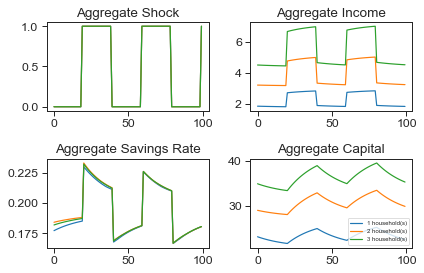

In [9]:
""" Create aggregate plots for policy iteration """

x = [i for i in range(100)]
plt.subplot(2, 2, 1)
for i in range(len([1,2,3])):
    sn.lineplot(x,shock_agg_list[i][:100], label = f"{i+1} household(s)", legend=0)
plt.title("Aggregate Shock")

plt.subplot(2, 2, 2)
for i in range(len([1,2,3])):
    sn.lineplot(x,y_agg_list[i][:100], label = f"{i+1} household(s)", legend=0)
plt.title("Aggregate Income")

plt.subplot(2, 2, 3)
for i in range(len([1,2,3])):
    sn.lineplot(x,s_agg_list[i][:100], label = f"{i+1} household(s)", legend=0)
plt.title("Aggregate Savings Rate")

plt.subplot(2, 2, 4)
for i in range(len([1,2,3])):
    sn.lineplot(x,k_agg_list[i][:100], label = f"{i+1} household(s)", legend=0)
plt.title("Aggregate Capital")

plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='lower right', prop={'size': 6})
plt.savefig(OUTPUT_PATH_FIGURES + "SimAgg_econ_" + exp_names[-1] + ".png")
plt.clf
plt.show()

In [10]:
""" Step 5: Simulate the model and get statistics """
y_agg_list = [[] for i in n_agents_list]
s_agg_list = [[] for i in n_agents_list]
c_agg_list = [[] for i in n_agents_list]
k_agg_list = [[] for i in n_agents_list]
k_max_list = [[] for i in n_agents_list]
k_min_list = [[] for i in n_agents_list]
s_max_list = [[] for i in n_agents_list]
s_min_list = [[] for i in n_agents_list]
shock_agg_list = [[] for i in n_agents_list]
p_list = [[] for i in n_agents_list]

for ind, n_hh in enumerate(n_agents_list):
    """ Step 4.0: replicate original environemnt and config """
    env_label = "capital_market"
    register_env(env_label, CapitalMarket)
    env_horizon = 1000
    n_hh = n_hh
    n_capital = 1
    beta = 0.98
    env_config_simul = {
        "horizon": 1000,
        "n_hh": n_hh,
        "n_capital": n_capital,
        "eval_mode": False,
        "simul_mode": True,
        "analysis_mode": False,
        "max_savings": 0.6,
        "bgt_penalty": 1,
        "shock_idtc_values": [0.9, 1.1],
        "shock_idtc_transition": [[0.9, 0.1], [0.1, 0.9]],
        "shock_agg_values": [0.8, 1.2],
        "shock_agg_transition": [[0.95, 0.05], [0.05, 0.95]],
        "parameters": {"delta": 0.04, "alpha": 0.3, "phi": 0.5, "beta": beta},
    }

    # We instantiate the environment to extract information.
    env = CapitalMarket(env_config_simul)
    config_analysis = {
        "gamma": beta,
        "env": env_label,
        "env_config": env_config_simul,
        "horizon": env_horizon,
        "explore": False,
        "framework": "torch",
        "multiagent": {
            "policies": {
                "hh": (
                    None,
                    env.observation_space["hh_0"],
                    env.action_space["hh_0"],
                    {},
                ),
            },
            "policy_mapping_fn": (lambda agent_id: agent_id.split("_")[0]),
            "replay_mode": "independent",
        },
    }
    """ Step 4.1: restore trainer """

    # restore the trainer
    trained_trainer = PPOTrainer(env=env_label, config=config_analysis)
    trained_trainer.restore(checkpoints_dirs[ind])

    """ Simulate an episode (SIMUL_PERIODS timesteps) """
    shock_idtc_list = [[] for i in range(env.n_hh)]
    y_list = [[] for i in range(env.n_hh)]
    s_list = [[] for i in range(env.n_hh)]
    c_list = [[] for i in range(env.n_hh)]
    k_list = [[] for i in range(env.n_hh)]

    # loop
    obs = env.reset()
    for t in range(SIMUL_PERIODS):
        action = {}
        if t%1000 == 0:
            obs=env.reset()
        for i in range(env.n_hh):
            action[f"hh_{i}"] = trained_trainer.compute_action(
                obs[f"hh_{i}"], policy_id="hh"
            )

        obs, rew, done, info = env.step(action)
        for i in range(env.n_hh):
            shock_idtc_list[i].append(obs["hh_0"][1][i])
            y_list[i].append(info["hh_0"]["income"][i])
            s_list[i].append(info["hh_0"]["savings"][i][0])
            c_list[i].append(info["hh_0"]["consumption"][i])
            k_list[i].append(info["hh_0"]["capital"][i][0])

        # k_agg_list.append(np.sum([k_list[[j][t-1] for j in range(env_loop.n_hh)]))
        shock_agg_list[ind].append(obs["hh_0"][2])
        y_agg_list[ind].append(np.sum([y_list[i][t] for i in range(env.n_hh)]))
        s_agg_list[ind].append(
            np.sum([s_list[i][t] * y_list[i][t] for i in range(env.n_hh)])
            / y_agg_list[ind][t]
        )
        c_agg_list[ind].append(np.sum([y_list[i][t] for i in range(env.n_hh)]))
        k_agg_list[ind].append(np.sum([k_list[i][t] for i in range(env.n_hh)]))
        k_max_list[ind].append(np.max([k_list[i][t] for i in range(env.n_hh)]))
        k_min_list[ind].append(np.min([k_list[i][t] for i in range(env.n_hh)]))
        s_max_list[ind].append(np.max([s_list[i][t] for i in range(env.n_hh)]))
        s_min_list[ind].append(np.min([s_list[i][t] for i in range(env.n_hh)]))
        p_list[ind].append(info["hh_0"]["price"][0])

    exp_data_simul_dict["n_hh"].append(n_hh)
    exp_data_simul_dict["Mean Agg. K"].append(np.mean(k_agg_list[ind]))
    exp_data_simul_dict["S.D. Agg. K"].append(np.std(k_agg_list[ind]))
    exp_data_simul_dict["Max K"].append(np.max(k_max_list[ind]))
    exp_data_simul_dict["Min K"].append(np.min(k_min_list[ind]))
    exp_data_simul_dict["Mean Agg. s"].append(np.mean(s_agg_list[ind]))
    exp_data_simul_dict["S.D. Agg. s"].append(np.std(s_agg_list[ind]))
    exp_data_simul_dict["Max s"].append(np.max(s_max_list[ind]))
    exp_data_simul_dict["Min s"].append(np.min(s_min_list[ind]))
    exp_data_simul_dict["Mean Price"].append(np.mean(p_list[ind]))
    exp_data_simul_dict["S.D. Price"].append(np.std(p_list[ind]))

(pid=34365) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=34365) Instructions for updating:
(pid=34365) non-resource variables are not supported in the long term
(pid=34374) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=34374) Instructions for updating:
(pid=34374) non-resource variables are not supported in the long term
2021-08-30 09:33:52,693	INFO trainable.py:377 -- Restored on 10.17.83.159 from checkpoint: /Users/matiascovarrubias/ray_results/native_1hh_cap_mar

In [11]:
""" Step 6: Simulate the Plocy Iteration model and get statistics """
y_agg_list = [[] for i in n_agents_list]
s_agg_list = [[] for i in n_agents_list]
c_agg_list = [[] for i in n_agents_list]
k_agg_list = [[] for i in n_agents_list]
k_max_list = [[] for i in n_agents_list]
k_min_list = [[] for i in n_agents_list]
s_max_list = [[] for i in n_agents_list]
s_min_list = [[] for i in n_agents_list]
shock_agg_list = [[] for i in n_agents_list]
p_list = [[] for i in n_agents_list]

for ind, n_hh in enumerate([1,2,3]):
    """ Step 4.0: replicate original environemnt and config """
    env_label = "capital_market"
    register_env(env_label, CapitalMarket)
    env_horizon = 1000
    n_hh = n_hh
    n_capital = 1
    beta = 0.98
    env_config_simul = {
        "horizon": 1000,
        "n_hh": n_hh,
        "n_capital": n_capital,
        "eval_mode": False,
        "simul_mode": True,
        "analysis_mode": False,
        "max_savings": 0.6,
        "bgt_penalty": 1,
        "shock_idtc_values": [0.9, 1.1],
        "shock_idtc_transition": [[0.9, 0.1], [0.1, 0.9]],
        "shock_agg_values": [0.8, 1.2],
        "shock_agg_transition": [[0.95, 0.05], [0.05, 0.95]],
        "parameters": {"delta": 0.04, "alpha": 0.3, "phi": 0.5, "beta": beta},
    }

    # We instantiate the environment to extract information.
    env = CapitalMarket(env_config_simul)
    config_analysis = {
        "gamma": beta,
        "env": env_label,
        "env_config": env_config_simul,
        "horizon": env_horizon,
        "explore": False,
        "framework": "torch",
        "multiagent": {
            "policies": {
                "hh": (
                    None,
                    env.observation_space["hh_0"],
                    env.action_space["hh_0"],
                    {},
                ),
            },
            "policy_mapping_fn": (lambda agent_id: agent_id.split("_")[0]),
            "replay_mode": "independent",
        },
    }
    """ Step 4.1: restore trainer """

    dir_model = f"cap_market_{n_hh}hh_11pts"
    matlab_struct = sio.loadmat(dir_policy_folder + dir_model, simplify_cells=True)
    if n_hh == 1:
        K_grid = [
            np.array(matlab_struct["IterRslt"]["var_state"][f"K"]) for i in range(n_hh)
        ]
    else:
        K_grid = [
            np.array(matlab_struct["IterRslt"]["var_state"][f"K_{i+1}"])
            for i in range(n_hh)
        ]
    shock_grid = np.array([i for i in range(matlab_struct["IterRslt"]["shock_num"])])
    if n_hh == 1:
        s_on_grid = [matlab_struct["IterRslt"]["var_policy"]["s"] for i in range(n_hh)]
    else:
        s_on_grid = [
            matlab_struct["IterRslt"]["var_policy"][f"s_{i+1}"] for i in range(n_hh)
        ]

    s_interp = [
        RegularGridInterpolator((shock_grid,) + tuple(K_grid), s_on_grid[i])
        for i in range(n_hh)
    ]

    def compute_action(obs, policy_list: list, max_action: float, K_grid: list):
        K = [min(max(obs[0][i],min(K_grid[i])), max(K_grid[i])) for i in range(n_hh)]
        shock_raw = [obs[2]] + list(obs[1])
        shock_id = encode(shock_raw, dims=[2 for i in range(env.n_hh + 1)])
        s = [policy_list[i](np.array([shock_id] + K)) for i in range(env.n_hh)]
        action = np.array([2 * s[i] / max_action - 1 for i in range(env.n_hh)])
        return action

    """ Simulate an episode (SIMUL_PERIODS timesteps) """
    shock_idtc_list = [[] for i in range(env.n_hh)]
    y_list = [[] for i in range(env.n_hh)]
    s_list = [[] for i in range(env.n_hh)]
    c_list = [[] for i in range(env.n_hh)]
    k_list = [[] for i in range(env.n_hh)]

    # loop
    obs = env.reset()
    for t in range(SIMUL_PERIODS):
        action = {}
        if t%1000 == 0:
            obs=env.reset()
        for i in range(env.n_hh):
            action[f"hh_{i}"] = compute_action(obs["hh_0"], s_interp, env.max_s_ij, K_grid)[i]

        obs, rew, done, info = env.step(action)
        for i in range(env.n_hh):
            shock_idtc_list[i].append(obs["hh_0"][1][i])
            y_list[i].append(info["hh_0"]["income"][i])
            s_list[i].append(info["hh_0"]["savings"][i][0])
            c_list[i].append(info["hh_0"]["consumption"][i])
            k_list[i].append(info["hh_0"]["capital"][i][0])

        # k_agg_list.append(np.sum([k_list[[j][t-1] for j in range(env_loop.n_hh)]))
        shock_agg_list[ind].append(obs["hh_0"][2])
        y_agg_list[ind].append(np.sum([y_list[i][t] for i in range(env.n_hh)]))
        s_agg_list[ind].append(
            np.sum([s_list[i][t] * y_list[i][t] for i in range(env.n_hh)])
            / y_agg_list[ind][t]
        )
        c_agg_list[ind].append(np.sum([y_list[i][t] for i in range(env.n_hh)]))
        k_agg_list[ind].append(np.sum([k_list[i][t] for i in range(env.n_hh)]))
        k_max_list[ind].append(np.max([k_list[i][t] for i in range(env.n_hh)]))
        k_min_list[ind].append(np.min([k_list[i][t] for i in range(env.n_hh)]))
        s_max_list[ind].append(np.max([s_list[i][t] for i in range(env.n_hh)]))
        s_min_list[ind].append(np.min([s_list[i][t] for i in range(env.n_hh)]))
        p_list[ind].append(info["hh_0"]["price"][0])

    exp_data_simul_econ_dict["n_hh"].append(n_hh)
    exp_data_simul_econ_dict["Mean Agg. K"].append(np.mean(k_agg_list[ind]))
    exp_data_simul_econ_dict["S.D. Agg. K"].append(np.std(k_agg_list[ind]))
    exp_data_simul_econ_dict["Max K"].append(np.max(k_max_list[ind]))
    exp_data_simul_econ_dict["Min K"].append(np.min(k_min_list[ind]))
    exp_data_simul_econ_dict["Mean Agg. s"].append(np.mean(s_agg_list[ind]))
    exp_data_simul_econ_dict["S.D. Agg. s"].append(np.std(s_agg_list[ind]))
    exp_data_simul_econ_dict["Max s"].append(np.max(s_max_list[ind]))
    exp_data_simul_econ_dict["Min s"].append(np.min(s_min_list[ind]))
    exp_data_simul_econ_dict["Mean Price"].append(np.mean(p_list[ind]))
    exp_data_simul_econ_dict["S.D. Price"].append(np.std(p_list[ind]))

In [12]:
print(exp_data_simul_econ_dict)

{'n_hh': [1, 2, 3], 'time to peak': [0.360690624, 3.464162213, 466.739593142], 'Mean Agg. K': [25.41061085603172, 33.66058563189653, 39.937684761955765], 'S.D. Agg. K': [2.191067617900484, 2.6392785880803045, 3.149340469104911], 'Max K': [32.03713000876987, 24.226253280901204, 19.109400779490443], 'Min K': [14.605377552546367, 9.958282361278771, 6.955502712590049], 'Mean Agg. s': [0.1981684016208899, 0.1994513211194922, 0.19740549617525296], 'S.D. Agg. s': [0.021912598616406022, 0.021637060949122475, 0.02071058762418854], 'Max s': [0.2702908851275487, 0.33724971943743043, 0.3326703408811147], 'Min s': [0.1529853096583255, 0.0779822500234673, 0.0593203063541742], 'Mean Price': [0.5078379432269506, 0.675469234451052, 0.8016752369456042], 'S.D. Price': [0.08655073964019014, 0.11220453724019143, 0.12659492894730892]}


In [14]:
""" Step 7: Table with moments """
exp_table_df = pd.DataFrame.from_dict(exp_data_simul_dict)
with open(OUTPUT_PATH_TABLES + exp_names[-1]+'_BIG_TABLE.tex','w') as tf:
    tf.write(exp_table_df.to_latex())

exp_table_small_df=exp_table_df[["n_hh","max rewards", "time to peak", "Mean Agg. K", "S.D. Agg. K", "Mean Price", "S.D. Price"]]
with open(OUTPUT_PATH_TABLES + exp_names[-1]+'_SMALL_TABLE.tex','w') as tf:
    tf.write(exp_table_small_df.to_latex())

exp_table_econ_df = pd.DataFrame.from_dict(exp_data_simul_econ_dict)
with open(OUTPUT_PATH_TABLES + exp_names[-1]+'_econ_BIG_TABLE.tex','w') as tf:
    tf.write(exp_table_econ_df.to_latex())

exp_table_small_econ_df=exp_table_df[["n_hh","max rewards", "time to peak", "Mean Agg. K", "S.D. Agg. K", "Mean Price", "S.D. Price"]]
with open(OUTPUT_PATH_TABLES + exp_names[-1]+'_econ_SMALL_TABLE.tex','w') as tf:
    tf.write(exp_table_small_econ_df.to_latex())

In [ ]:
shutdown()